# Ungraded Lab: Using Convolutional Neural Networks

In this lab, you will look at another way of building your text classification model and this will be with a convolution layer. As you learned in Course 2 of this specialization, convolutions extract features by applying filters to the input. Let's see how you can use that for text data in the next sections.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Download and prepare the dataset

In [ ]:
import tensorflow_datasets as tfds

# The dataset is already downloaded for you. For downloading you can use the code below.
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="./data/", download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.6MMJQ0_1.0.0/imdb_reviews-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.6MMJQ0_1.0.0/imdb_reviews-test.tfrecord*...:   0%|          …

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.6MMJQ0_1.0.0/imdb_reviews-unsupervised.tfrecord*...:   0%|  …

Dataset imdb_reviews downloaded and prepared to data/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Extract the train reviews and labels
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

# Extract the test reviews and labels
test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

In [ ]:
import os
try:
    import wget
except ModuleNotFoundError:
    print("Installing wget module...")
    !pip install wget
    import wget

def download_dataset(url, folder, filename):
    # Check if the folder exists, otherwise, create it
    if not os.path.exists(folder):
        os.makedirs(folder)

    file_path = os.path.join(folder, filename)

    # Check if the file has already been downloaded
    if not os.path.exists(file_path):
        print(f"Downloading file from {url}...")
        wget.download(url, out=folder)
        print("\nDownload completed.")
    else:
        print("The file has already been downloaded.")

# Specify the URL of the file, the destination folder, and the filename
url = "https://storage.googleapis.com/tensorflow-1-public/course3/imdb_vocab_subwords.txt"
folder = "Vocabulary"
filename = "imdb_vocab_subwords.txt"

# Call the function to download the file.
download_dataset(url, folder, filename)

Installing wget module...
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=3b5f1bcac21af5102b4807a367812562c28fb21064db84a6839ac1a99e13513f
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget

Download completed.


In [ ]:
import keras_nlp

# Initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./Vocabulary/imdb_vocab_subwords.txt'
)

In [ ]:
import tensorflow as tf

# Data pipeline and padding parameters
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 256
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [ ]:
def padding_func(sequences):
  '''
  Generates padded sequences from a tf.data.Dataset.

  Args:
      sequences (tf.data.Dataset): Dataset containing the sequences to be padded.

  Returns:
      tf.data.Dataset: Dataset containing the padded sequences.
  '''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                  truncating=TRUNC_TYPE,
                                                  padding=PADDING_TYPE
                                                 )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [ ]:
def process_reviews_with_tokenizer(reviews, labels, subword_tokenizer, padding_func):
    """
    Generate integer sequences using the subword tokenizer, apply padding, and combine sequences with labels.

    Args:
        reviews (tf.data.Dataset): Dataset containing text reviews.
        labels (tf.data.Dataset): Dataset containing labels.
        subword_tokenizer: Subword tokenizer used to tokenize the reviews.
        padding_func: Function used to apply padding to the tokenized sequences.

    Returns:
        tf.data.Dataset: Dataset containing the tokenized and padded sequences along with their labels.
    """
    # Generate integer sequences using the subword tokenizer and apply padding
    sequences_subword = reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

    # Combine the integer sequences and labels
    dataset_vectorized = tf.data.Dataset.zip((sequences_subword, labels))

    return dataset_vectorized

train_dataset_vectorized = process_reviews_with_tokenizer(train_reviews, train_labels, subword_tokenizer, padding_func)
test_dataset_vectorized = process_reviews_with_tokenizer(test_reviews, test_labels, subword_tokenizer, padding_func)

In [ ]:
def optimize_dataset(dataset_vectorized, shuffle=False):
    '''
    Optimizes the dataset for training.

    Args:
        dataset_vectorized (tf.data.Dataset): Dataset containing the vectorized data.
        shuffle (bool): Indicates whether to shuffle the dataset or not. Default is False.

    Returns:
        tf.data.Dataset: Optimized dataset with caching, prefetching, and batching applied.
    '''
    dataset_final = (dataset_vectorized.shuffle(SHUFFLE_BUFFER_SIZE) if shuffle else dataset_vectorized) \
                    .cache().prefetch(buffer_size=PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset_final

train_dataset_final = optimize_dataset(train_dataset_vectorized, shuffle=True)
test_dataset_final = optimize_dataset(test_dataset_vectorized)

## Build the Model

In Course 2, you were using 2D convolution layers because you were applying it on images. For temporal data such as text sequences, you will use [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D) instead so the convolution will happen over a single dimension. You will also append a pooling layer to reduce the output of the convolution layer. For this lab, you will use [GlobalMaxPooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D) to get the max value across the time dimension. You can also use average pooling and you will do that in the next labs. See how these layers behave as standalone layers in the cell below.

In [ ]:
import numpy as np

# Parameters
BATCH_SIZE = 1
TIMESTEPS = 20
FEATURES = 20
FILTERS = 128
KERNEL_SIZE = 5

print(f'batch_size: {BATCH_SIZE}')
print(f'timesteps (sequence length): {TIMESTEPS}')
print(f'features (embedding size): {FEATURES}')
print(f'filters: {FILTERS}')
print(f'kernel_size: {KERNEL_SIZE}')

# Define array input with random values
random_input = np.random.rand(BATCH_SIZE,TIMESTEPS,FEATURES)
print(f'shape of input array: {random_input.shape}')

# Pass array to convolution layer and inspect output shape
conv1d = tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu')
result = conv1d(random_input)
print(f'shape of conv1d output: {result.shape}')

# Pass array to max pooling layer and inspect output shape
gmp = tf.keras.layers.GlobalMaxPooling1D()
result = gmp(result)
print(f'shape of global max pooling output: {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 20
filters: 128
kernel_size: 5
shape of input array: (1, 20, 20)
shape of conv1d output: (1, 16, 128)
shape of global max pooling output: (1, 128)


You can build the model by simply appending the convolution and pooling layer after the embedding layer as shown below.

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

class ConvolutionalModel:
    def __init__(self, vocab_size, embedding_dim, filters, kernel_size, dense):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.filters = filters
        self.kernel_size = kernel_size
        self.dense_dim = dense
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Input(shape=(None,)),
            Embedding(self.vocab_size, self.embedding_dim),
            Conv1D(filters=self.filters, kernel_size=self.kernel_size, activation='relu'),
            GlobalMaxPooling1D(),
            Dense(self.dense_dim, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        return model

    def compile_model(self):
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train_model(self, train_data, test_data, num_epochs, verbose):
        history = self.model.fit(
            train_data,
            epochs=num_epochs,
            validation_data=test_data,
            verbose=verbose
        )
        return history

    def summary(self):
        self.model.summary()

In [ ]:
# Hyperparameters
EMBEDDING_DIM = 64
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 64

# Create an instance of the SentimentModel class
model = ConvolutionalModel(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM, FILTERS, KERNEL_SIZE, DENSE_DIM)

# Print the summary
model.summary()

# Compile the model
model.compile_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 64)            │         488,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, None, 128)           │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 538,049 (2.05 MB)

 Trainable params: 538,049 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

Training will take around 30 seconds per epoch and you will notice that it reaches higher accuracies than the previous models you've built.

In [ ]:
NUM_EPOCHS = 30

history = model.train_model(train_data=train_dataset_final, test_data=test_dataset_final, num_epochs=NUM_EPOCHS, verbose=1)

Epoch 1/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 48s 396ms/step - accuracy: 0.6012 - loss: 0.6568 - val_accuracy: 0.8293 - val_loss: 0.3830
Epoch 2/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 68s 327ms/step - accuracy: 0.8556 - loss: 0.3358 - val_accuracy: 0.8898 - val_loss: 0.2661
Epoch 3/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 331ms/step - accuracy: 0.9247 - loss: 0.1959 - val_accuracy: 0.8933 - val_loss: 0.2628
Epoch 4/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 331ms/step - accuracy: 0.9659 - loss: 0.1093 - val_accuracy: 0.8828 - val_loss: 0.3104
Epoch 5/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 330ms/step - accuracy: 0.9819 - loss: 0.0646 - val_accuracy: 0.8802 - val_loss: 0.3435
Epoch 6/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 330ms/step - accuracy: 0.9829 - loss: 0.0510 - val_accuracy: 0.8970 - val_loss: 0.3041
Epoch 7/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 328ms/step - accuracy: 0.9978 - loss: 0.0151 - val_accuracy: 0.8974 - val_loss: 0.3169
Epoch 8/30
98/98 ━━━━━━━━━━━━━━━━━━━━ 32s 330ms/step - accuracy: 0.9999 - loss: 0.0052 - val_accu

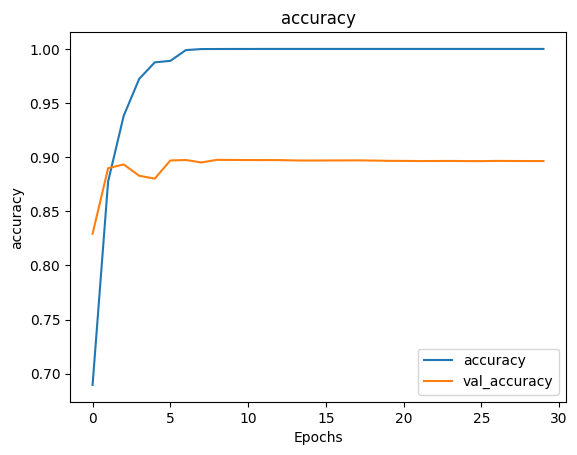

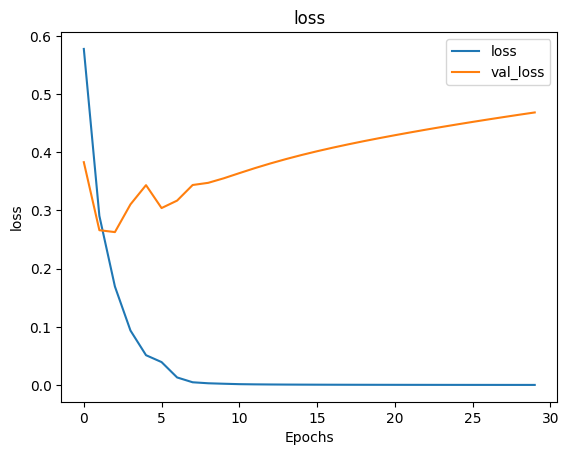

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    """
    Plots training and validation metrics over epochs.

    Args:
        history (History): History object returned by the fit method of a Keras model.
        metric (str): Metric name to plot (e.g., "accuracy", "loss").

    Returns:
        None: Displays a plot showing the training and validation metrics over epochs.
    """
    # Convert metric to lowercase
    metric = metric.lower()

    # Check if the metric exists in the history
    if metric not in history.history or f'val_{metric}' not in history.history:
        raise ValueError(f"Metric '{metric}' or 'val_{metric}' not found in history.")

    plt.figure()  # Create a new figure
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Save the history

In [ ]:
import json
from google.colab import files

def save_history(history, filename):
    """
    Saves the training history to a file.

    Args:
        history (History): History object returned by the fit method of a Keras model.
        filename (str): Name of the file where the history will be saved.

    Returns:
        None: The function saves the history to the specified file.
    """
    # Save the dictionary to a JSON file
    with open(filename, 'w') as file:
        json.dump(history.history, file)

    # Download the JSON file
    files.download(filename)

save_history(history, 'history.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Wrap Up

This lab showed how you can build deep networks by stacking LSTM layers. In the next labs, you will continue exploring other architectures you can use to implement your sentiment classification model.

As before, run the cell below to free up resources.

In [ ]:
# Shutdown the kernel to free up resources.
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)